In [30]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx, to_dense_adj

sys.path.append("../")
from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator
from spikeometric.stimulus import SinStimulus, PoissonStimulus

# Working with stimuli

In this example we will show how to work with stimuli, an essential part of the modelling workflow.

To stimulate a network with an external input we need two things:
1.  A callable that is added to the model by passing it to the `add_stimulus` method
2.  A stimulus mask of length `n_neurons` that tells us which neurons are targeted.

The callable can be user-defined function or one of the stimulus modules provided by the package. The stimulus modules extend `torch.nn.Module` and can be conveniently tuned using the model's `tune` method.

We'll start by showing how to pass a custom pre-defined stimulus function. Secondly, we'll use the `PoissonStimulus` to simulate the presence of an external neuron that projects to a some of the neurons in the network. We'll end by trying to synchronize the actvity of a network with the frequency of a sinusoidal stimulus.

### Passing a custom stimulus function
Sometimes there is no need to tune the stimulus and we simply want to stimulate some neurons with a stimulus that depends on time in a straight forward, pre-defined way. One such example could be a regular stimulus with a fixed period.

In [31]:
# Define the stimulus function
stim = lambda t: 2*(t % 1000 < 200)     # 10 ms long stimulus of strength 2 every 200 ms

# Define the model
model = BernoulliGLM(
    theta=5,
    dt=1.,
    coupling_window=20,
    abs_ref_scale=2,
    abs_ref_strength=-100,
    rel_ref_scale=7,
    rel_ref_strength=-30,    
    alpha=0.2,
    beta=0.5,
)
model.add_stimulus(stim)

# Let's stimulate neuron 0, 2, and 4
stim_mask = torch.isin(torch.arange(10), torch.tensor([0, 2, 4])) # Boolean mask [10]

# Define the dataset
data = NormalGenerator(10, mean=0, std=3).generate(1, add_self_loops=True, stimulus_masks=[stim_mask])[0] # 1 network, 10 neurons
spikes = model.simulate(data, n_steps=10000)

100%|██████████| 10000/10000 [00:00<00:00, 13987.06it/s]


Let's look at the average stimulus response to see how the stimulus affected the activity of the neurons throughout the
its period.

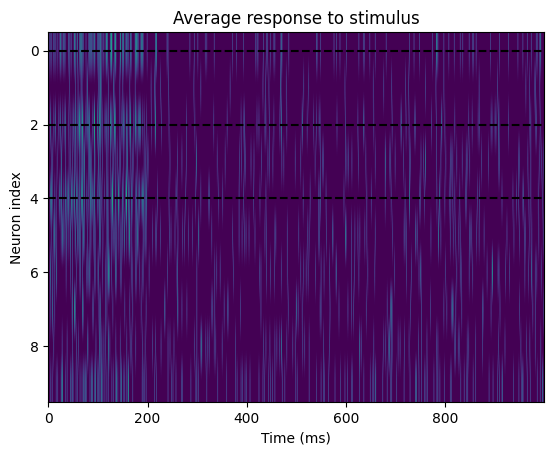

In [32]:
# Plot the results
stim_period = 1000
average_stim_response = spikes.float().reshape(10, -1, stim_period).mean(dim=1)

plt.imshow(average_stim_response, aspect="auto")

# plt.axvspan(0, 200, color="red", alpha=0.1)
plt.axhline(0, color="black", linestyle="--")
plt.axhline(2, color="black", linestyle="--")
plt.axhline(4, color="black", linestyle="--")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("Average response to stimulus")

plt.show()

The effect of the stimulus on neurons 0, 2 and 4 is very clear.

### Adding a confounding stimulus
Causal inference has been a hot topic in neuroscience recently. We'll now quickly look at *why* by using the `PoissonStimulaton` class to add a confounding neuron that projects to two otherwise unconnected neurons and looking at the cross-correlation histogram to see the spurious correlation introduced.

In [33]:
n_neurons = 6
n_steps = 10000
network = NormalGenerator(n_neurons, mean=0, std=5, rng=torch.Generator().manual_seed(532)).generate(1, add_self_loops=True)[0]

Let's identify a pair of unconnected neurons by plotting the network

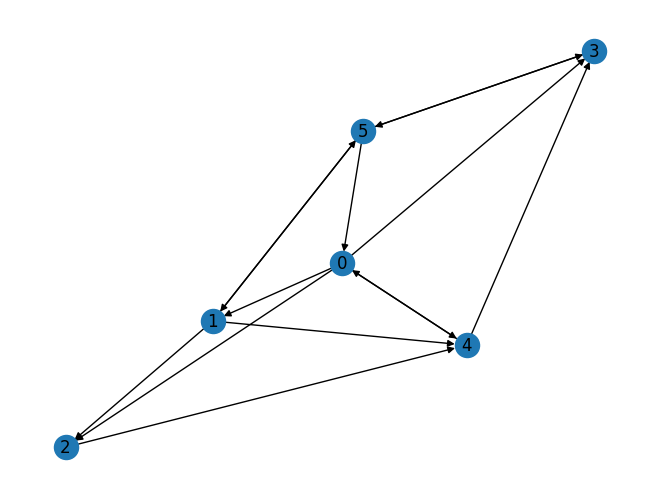

In [34]:
G = to_networkx(network, remove_self_loops=True)
nx.draw(G, with_labels=True)

We see that 2 and 3 are not directly connected, so we'll choose them as our targets.

In [35]:
stimulus_mask = torch.isin(torch.arange(n_neurons), torch.tensor([2, 3]))

Let's run a simulation without the confounding neuron first, so that we have a baseline to compare the results to.

In [36]:
model = BernoulliGLM(
    theta=5,
    dt=1.,
    coupling_window=20,
    abs_ref_scale=2,
    abs_ref_strength=-100,
    rel_ref_scale=7,
    rel_ref_strength=-30,    
    alpha=0.2,
    beta=0.5,
)

In [37]:
spikes = model.simulate(network, n_steps=100000)

100%|██████████| 100000/100000 [00:05<00:00, 17431.40it/s]


We calculate the cross-correlogram and compare it to the true weights

In [38]:
binned_spikes = spikes.reshape(n_neurons, -1, 20).sum(2)
corr = torch.corrcoef(binned_spikes)
corr[torch.eye(n_neurons, dtype=torch.bool)] = 0

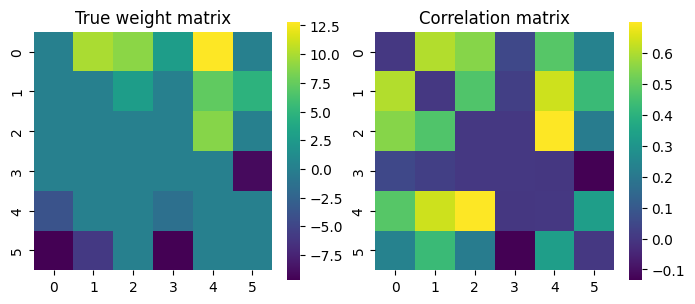

In [39]:
square_W0 = to_dense_adj(network.edge_index, edge_attr=network.W0)[0]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))

# We normalize both plots to the same range [0, 1] for better comparison
sns.heatmap(corr, ax=ax1, square=True, cmap="viridis")
sns.heatmap(square_W0, ax=ax0, square=True, cmap="viridis")

ax0.set_title("True weight matrix")
ax1.set_title("Correlation matrix")

plt.tight_layout()
plt.savefig("../docs/_static/no_confounding.png")

We see that the cross-correlogram picks up on some of the edges and that 2 and 3 are relatively uncorrelated, as expected.

Now we add a confounding neuron that is firing with the average interspike interval of the network and try again. We'll give it a strength comparable
to the average excitatory synapse in the network.

In [40]:
sim_isi = 1/spikes.float().mean().item()
average_excitatory = network.W0[network.W0 > 0].mean().item()
stimulus = PoissonStimulus(strength=average_excitatory, mean_interval=sim_isi, duration=100000, tau=3)
model.add_stimulus(stimulus)

network.stimulus_mask = stimulus_mask

confounded_spikes = model.simulate(network, n_steps=100000)

100%|██████████| 100000/100000 [00:08<00:00, 11774.16it/s]


In [41]:
binned_confounded_spikes = confounded_spikes.reshape(n_neurons, -1, 10).sum(2)
confounded_corr = torch.corrcoef(binned_confounded_spikes)
confounded_corr[torch.eye(n_neurons, dtype=torch.bool)] = 0

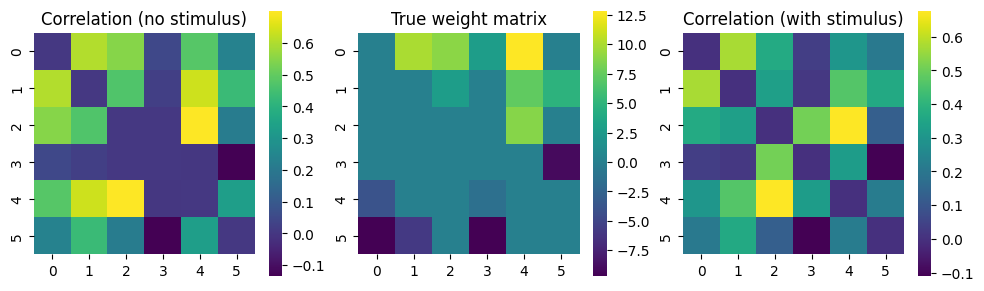

In [42]:
fig = plt.figure(figsize=(10, 3))

gs = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.heatmap(corr, ax=ax0, square=True, cmap="viridis")
ax0.set_title("Correlation (no stimulus)")

sns.heatmap(square_W0, ax=ax1, square=True, cmap="viridis")
ax1.set_title("True weight matrix")

sns.heatmap(confounded_corr, ax=ax2, square=True, cmap="viridis")
ax2.set_title("Correlation (with stimulus)")

plt.tight_layout()
plt.show()

We see that the presence of a common source has added a correlation between 2 and 3 that is not due to any synaptic connection.

## Synchronizing the network with a sinusiodal stimulus
For our final example, we'll show how to use the tuning functionality for stimuli.

We'll use the `SinStimulus` to drive a set of networks, and try to to synchronize the activitity of the network to match the frequency of the stimulus.


In [44]:
n_neurons = 20
n_steps= 1000
n_networks = 10

# We stimulate half of the excitatory neurons
stim_masks = [torch.isin(torch.arange(n_neurons), torch.randperm(n_neurons // 2)[:n_neurons // 4]) for _ in range(n_networks)]
data = NormalGenerator(n_neurons, mean=0, std=5, glorot=True).generate(n_networks, add_self_loops=True, stimulus_masks=stim_masks)
data_loader = DataLoader(data, batch_size=10, shuffle=False)

model = BernoulliGLM(
    theta=5,
    dt=1.,
    coupling_window=20,
    abs_ref_scale=2,
    abs_ref_strength=-100,
    rel_ref_scale=7,
    rel_ref_strength=-30,    
    alpha=0.2,
    beta=0.5,
)

stimulus = SinStimulus(
    amplitude=1,
    period=100, # frequency = 1/period = 10 Hz
    duration=n_steps,
)

The `tune` method can selectively tune specific parameters by passing a list of parameter names with the `tunable_parameters` argument. However, we can also tune
all the stimulus parameters by setting `tunable_parameters="stimulus"` or all the model parameters by setting `tunable_parameters="model"`. Note that if you want to tune specific stimulus parameters you must prefix them by `stimulus.` (ex. `stimulus.amplitude`).

We'll tune the stimulus parameters to give an average firing rate of 10 Hz in the network.

In [47]:
model.add_stimulus(stimulus)
for data in data_loader:
    model.tune(data, 10, tunable_parameters="stimulus", n_epochs=100, n_steps=500, lr=0.01)

Tuning... fr=9.99142: 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Let's see how the tuning changed the stimulus

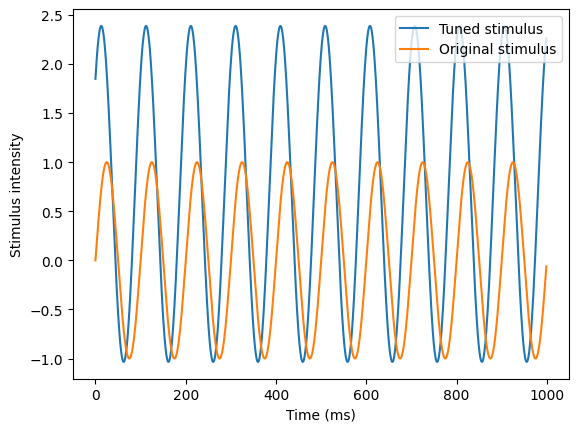

In [55]:
plt.plot(torch.arange(0, 1000,), stimulus(torch.arange(0, 1000,)), label="Tuned stimulus")
plt.plot(torch.arange(0, 1000,), torch.sin(2*torch.pi*torch.arange(0, 1000,)/100), label="Original stimulus")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Stimulus intensity")
plt.show()

Now we simulate the network

In [49]:
results = torch.zeros((n_neurons*10, n_steps))
for i, data in enumerate(data_loader):
    results = model.simulate(data, n_steps=n_steps)

100%|██████████| 1000/1000 [00:00<00:00, 1815.07it/s]


Finally, we check if the average firing rate matches the stimulus frequencey and make a raster plot and PSTH.

In [54]:
print("Average firing rate:", results.float().mean().item()*1000)
print("Stimulus frequency:", 1000/stimulus.period.item())

Average firing rate: 10.514999739825726
Stimulus frequency: 10.078554160540836


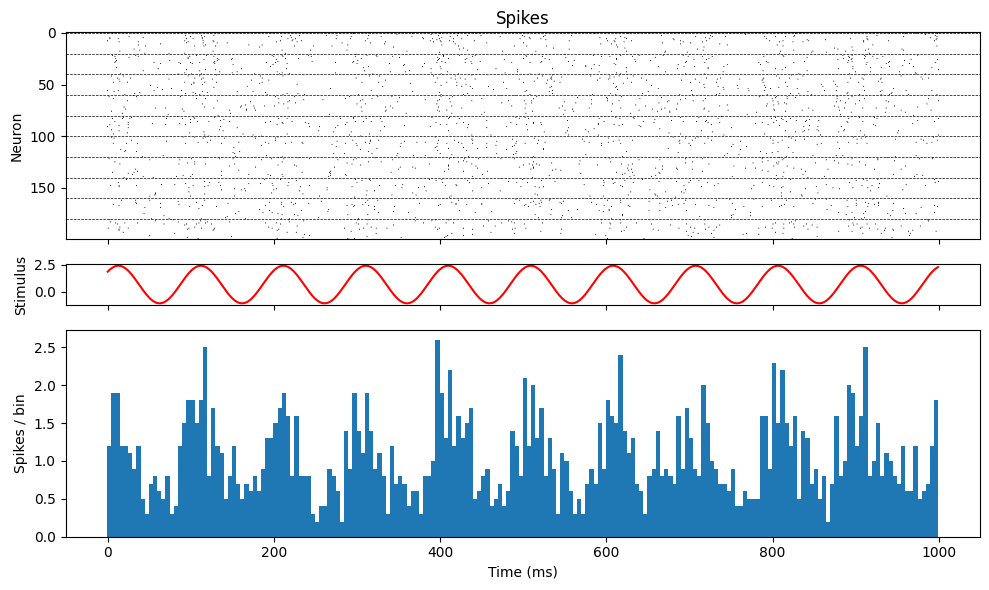

In [53]:
time_window = 1000

fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [1, 0.2, 1]})

ax[0].imshow(results, aspect="auto", cmap="binary")
ax[0].set_title("Spikes")
ax[0].set_ylabel("Neuron")
for i in range(10):
    ax[0].axhline(i*n_neurons, linestyle="--", color="black", linewidth=0.5)

ax[1].plot(np.arange(time_window), stimulus(torch.arange(time_window)), color="red")
ax[1].set_ylabel("Stimulus")

bin = 5
binned_spikes = results.float().reshape(results.shape[0], -1, bin).sum(dim=(2,0)).repeat_interleave(bin) / 10
ax[2].bar(np.arange(time_window), binned_spikes, width=1.2)
ax[2].set_xlabel("Time (ms)")
ax[2].set_ylabel("Spikes / bin")

plt.tight_layout()
plt.show()